In [1]:
!pip install folium

In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins

In [2]:
cdata=pd.read_csv("train.csv")

In [50]:
#Cross validation using K-fold
from sklearn.model_selection import KFold, cross_val_score

#Split the data into 10 and shuflles data before kfold splits the data
kfold = KFold(n_splits=10, shuffle = True)

# Benchmark (without pre-processing data)

In [3]:
#fill in the missing value with 0, selecting LA listings only, and selecting numeric variables only for benchmark
cdata.fillna(0,inplace=True)
cla =cdata[cdata.city == "LA"]
raw_la= pd.DataFrame(cla, columns=['log_price', 'accommodates','bathrooms','number_of_reviews','review_scores_rating','bedrooms','beds','latitude','longitude'])


In [4]:
#categorize log price with average log price
raw_la.log_price.mean()

4.72049630665993

In [5]:
#categorize log price into 2 groups:0-low and 1-high
raw_la.loc[raw_la["log_price"] <4.72,"log_price"] = 0
raw_la.loc[raw_la["log_price"] >=4.72,"log_price"] = 1

In [6]:
#categorize log price into 2 groups:0-low and 1-high
result = pd.DataFrame()
result['log_price'] = raw_la.iloc[:,0]
result

,log_price
6,0.0
7,1.0
9,0.0
11,1.0
12,0.0
...,...
74101,0.0
74102,0.0
74105,0.0
74107,1.0


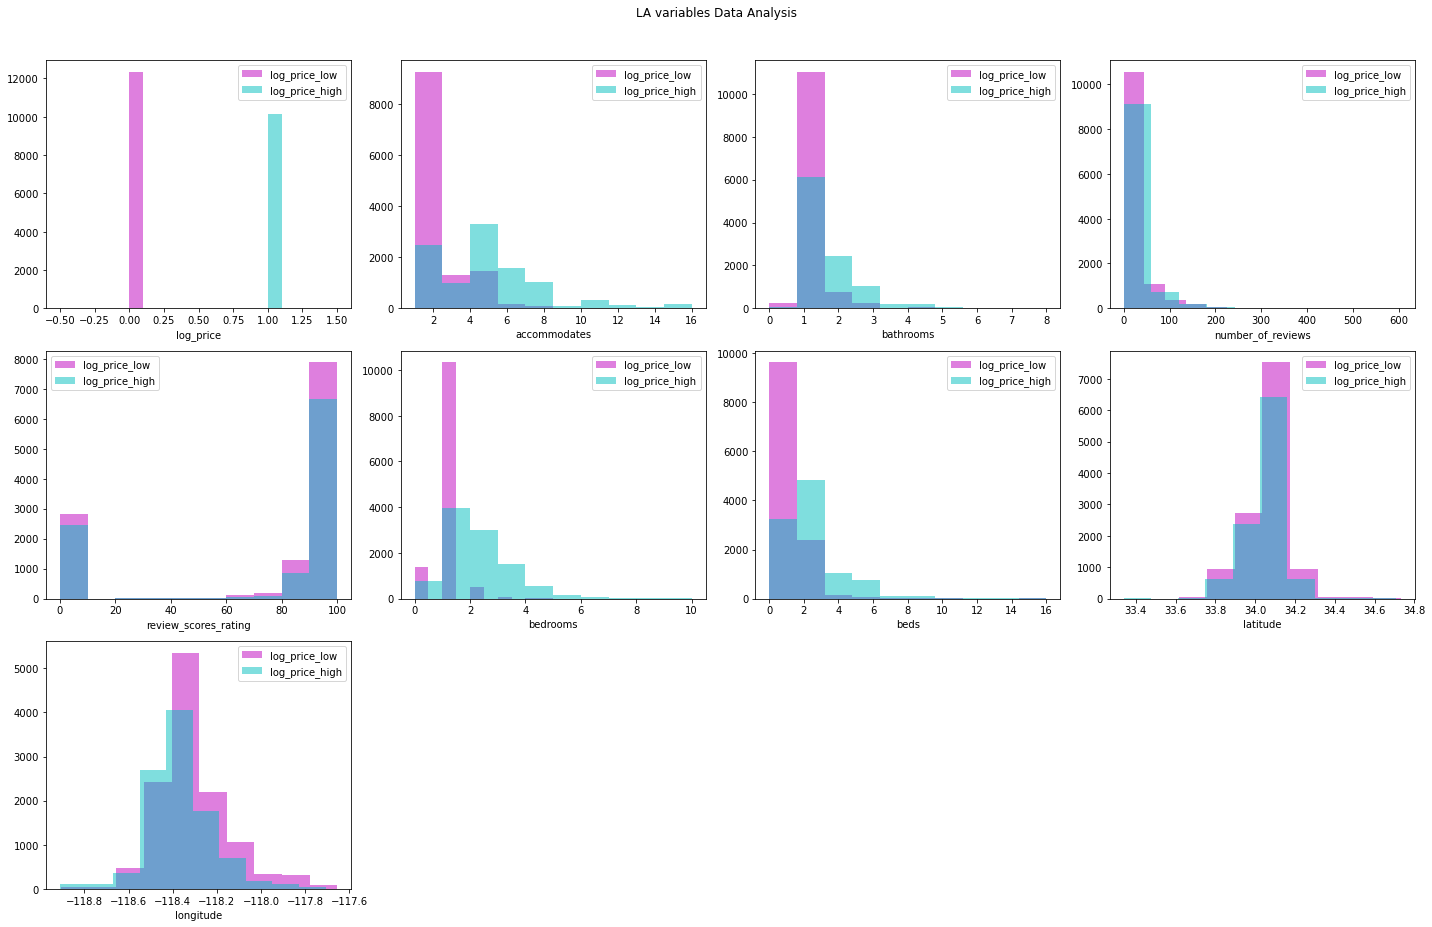

In [7]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in raw_la.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    plt.hist(raw_la[i][result['log_price']==0],alpha = 0.5, color = "m", label = 'log_price_low')
    plt.hist(raw_la[i][result['log_price']==1],alpha = 0.5, color = "c", label = 'log_price_high')
    plt.legend(loc='best')
    plt.xlabel(i)
fig.suptitle('LA variables Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### Correlation Heatmap 

<AxesSubplot:>

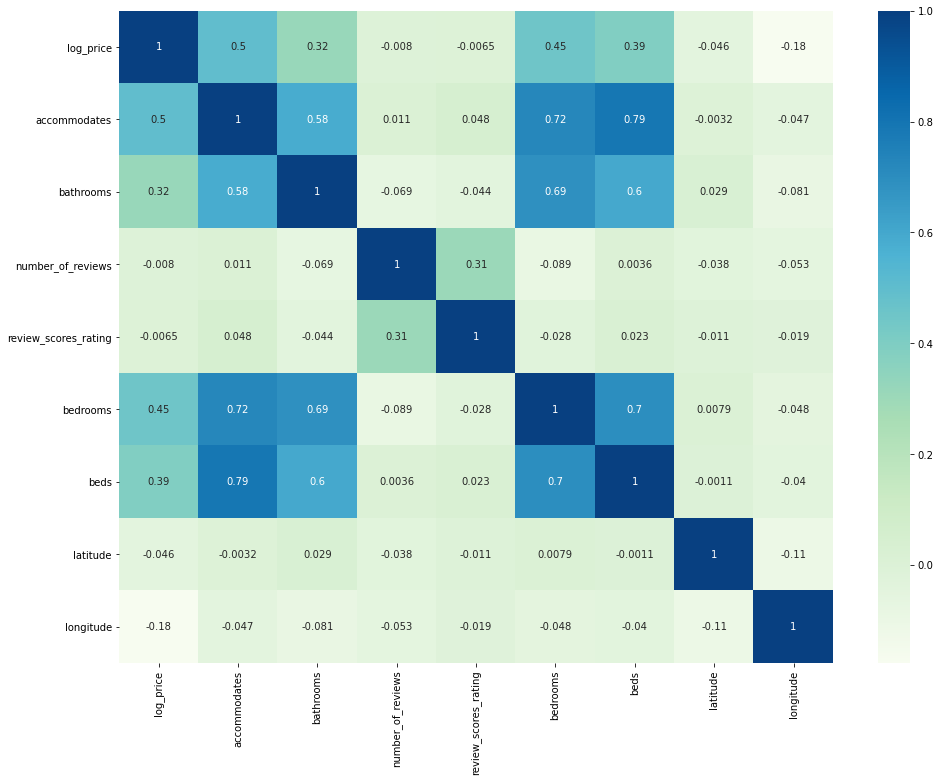

In [8]:
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12))
sns.heatmap(raw_la.corr(),cmap='GnBu',annot=True)

In [9]:
#logisticRegression
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [10]:
#Set log_price as dependent variable, all others are independent variables
rawlaLR =raw_la.copy()
X_rawlr = rawlaLR.drop(['log_price'], axis=1)
y_rawlr = rawlaLR.log_price
# Splitting data to train and test
from sklearn.model_selection import train_test_split
X_raw_LRtrain, X_raw_LRtest, y_raw_LRtrain, y_raw_LRtest = train_test_split(X_rawlr,y_rawlr,train_size=0.7,random_state=1234)

In [11]:
#regression result
import warnings
warnings.filterwarnings("ignore") 
from sklearn.model_selection import GridSearchCV
logreg_raw = LogisticRegression()

logreg_raw.fit(X_raw_LRtrain, y_raw_LRtrain)
est_raw = sm.Logit(y_raw_LRtrain, X_raw_LRtrain.astype(float)).fit()
print(est_raw.summary())

Optimization terminated successfully.
         Current function value: 0.502679
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              log_price   No. Observations:                15717
Model:                          Logit   Df Residuals:                    15709
Method:                           MLE   Df Model:                            7
Date:                Wed, 09 Dec 2020   Pseudo R-squ.:                  0.2701
Time:                        16:00:23   Log-Likelihood:                -7900.6
converged:                       True   LL-Null:                       -10825.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
accommodates             0.6736      0.021     31.691      0.000       0.632       0.715

### P>|t| is 0 which is means there are statistically significant at alpha level 0.05.
### From our results, we see that
### The p-value of 0.000 for accommodates,bathrooms,review_score_rating,bedrooms,beds,latitude,longitude implies that log_price is statistically significant (using p < 0.05 as a rejection rule).
### The R-squared value of 0.603 indicates that around 60% of the variation in log_price is explained by independent variables. 

Accuracy of logistic regression  classifier on test set: 0.78
Confusion Matrix
[[3301  428]
 [1068 1939]]
              precision    recall  f1-score   support

         0.0       0.76      0.89      0.82      3729
         1.0       0.82      0.64      0.72      3007

    accuracy                           0.78      6736
   macro avg       0.79      0.77      0.77      6736
weighted avg       0.78      0.78      0.77      6736



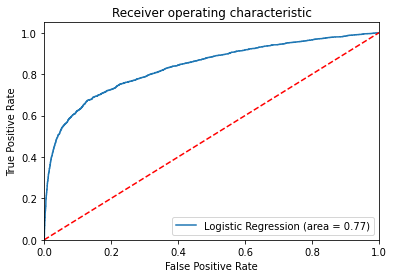

In [12]:
#accuracy
y_predition_raw = logreg_raw.predict(X_raw_LRtest)
print('Accuracy of logistic regression  classifier on test set: {:.2f}'.format(logreg_raw.score(X_raw_LRtest, y_raw_LRtest)))
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_raw = confusion_matrix(y_raw_LRtest, y_predition_raw)
print('Confusion Matrix')
print(confusion_matrix_raw)
#report
print(classification_report(y_raw_LRtest,y_predition_raw))
#ROC
logit_roc_auc_raw = roc_auc_score(y_raw_LRtest, logreg_raw.predict(X_raw_LRtest))
fpr, tpr, thresholds = roc_curve(y_raw_LRtest, logreg_raw.predict_proba(X_raw_LRtest)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_raw)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Naive Bayes

In [13]:
#Naive Bayes
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [14]:
raw_la.mean()

log_price                 0.451076
accommodates              3.407251
bathrooms                 1.346568
number_of_reviews        21.304948
review_scores_rating     72.183583
bedrooms                  1.333497
beds                      1.860642
latitude                 34.056477
longitude              -118.333835
dtype: float64

In [15]:
lanb_bench = raw_la.copy()
lanb_bench.loc[lanb_bench["accommodates"] <3.41,"accommodates"] = 0
lanb_bench.loc[lanb_bench["accommodates"] >=3.41,"accommodates"] = 1

lanb_bench.loc[lanb_bench["bathrooms"] <1.35,"bathrooms"] = 0
lanb_bench.loc[lanb_bench["bathrooms"] >=1.35,"bathrooms"] = 1

lanb_bench.loc[lanb_bench["number_of_reviews"] <21.30,"number_of_reviews"] = 0
lanb_bench.loc[lanb_bench["number_of_reviews"] >=21.30,"number_of_reviews"] = 1

lanb_bench.loc[lanb_bench["review_scores_rating"] <72.18,"review_scores_rating"] = 0
lanb_bench.loc[lanb_bench["review_scores_rating"] >=72.18,"review_scores_rating"] = 1

lanb_bench.loc[lanb_bench["bedrooms"] <1.33,"bedrooms"] = 0
lanb_bench.loc[lanb_bench["bedrooms"] >=1.33,"bedrooms"] = 1

lanb_bench.loc[lanb_bench["beds"] <1.86,"beds"] = 0
lanb_bench.loc[lanb_bench["beds"] >=1.86,"beds"] = 1

lanb_bench.loc[lanb_bench["latitude"] <34.06,"latitude"] = 0
lanb_bench.loc[lanb_bench["latitude"] >=34.06,"latitude"] = 1

lanb_bench.loc[abs(lanb_bench["longitude"]) < abs(lanb_bench.longitude.mean()),"longitude"] = 0
lanb_bench.loc[abs(lanb_bench["longitude"]) >= abs(lanb_bench.longitude.mean()),"longitude"] = 1

In [16]:
#Set log_price as dependent variable, all others are independent variables
X_feature_raw =lanb_bench.drop(['log_price'],axis =1).values
X_target_raw = lanb_bench.loc[:, 'log_price'].values

accuracy score: 0.7541567695961995
[[3159  538]
 [1118 1921]]
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      3697
         1.0       0.78      0.63      0.70      3039

    accuracy                           0.75      6736
   macro avg       0.76      0.74      0.75      6736
weighted avg       0.76      0.75      0.75      6736



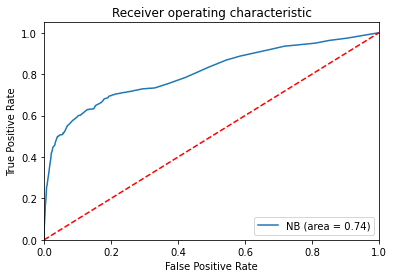

In [17]:
feature_train_raw, feature_test_raw, target_train_raw, target_test_raw = train_test_split(X_feature_raw, X_target_raw, test_size=0.3,random_state=0)
 
NB=BernoulliNB()
NB.fit(feature_train_raw,target_train_raw)
predict_results_raw=NB.predict(feature_test_raw)
print("accuracy score:", accuracy_score(predict_results_raw, target_test_raw))
 
conf_mat_raw = confusion_matrix(target_test_raw, predict_results_raw)
 
print(conf_mat_raw)
 
print(classification_report(target_test_raw, predict_results_raw))
#ROC
nb_roc_auc_raw = roc_auc_score(target_test_raw, NB.predict(feature_test_raw))
fpr, tpr, thresholds = roc_curve(target_test_raw, NB.predict_proba(feature_test_raw)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='NB (area = %0.2f)' % nb_roc_auc_raw)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('NB_ROC')
plt.show()

In [18]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [19]:
#nyc X_raw_LRtrain, X_raw_LRtest, y_raw_LRtrain, y_raw_LRtest
rawrf = raw_la.copy()

[Text(558.0, 978.48, 'review_scores_rating <= 95.5\ngini = 0.496\nsamples = 9956\nvalue = [8545, 7172]'),
 Text(279.0, 761.0400000000001, 'longitude <= -118.338\ngini = 0.493\nsamples = 5562\nvalue = [4900, 3887]'),
 Text(139.5, 543.6, 'bedrooms <= 1.5\ngini = 0.499\nsamples = 3040\nvalue = [2273, 2531]'),
 Text(69.75, 326.1600000000001, 'accommodates <= 2.5\ngini = 0.455\nsamples = 2102\nvalue = [2171, 1173]'),
 Text(34.875, 108.72000000000003, 'gini = 0.395\nsamples = 1462\nvalue = [1708, 634]'),
 Text(104.625, 108.72000000000003, 'gini = 0.497\nsamples = 640\nvalue = [463, 539]'),
 Text(209.25, 326.1600000000001, 'accommodates <= 2.5\ngini = 0.13\nsamples = 938\nvalue = [102, 1358]'),
 Text(174.375, 108.72000000000003, 'gini = 0.498\nsamples = 27\nvalue = [25, 22]'),
 Text(244.125, 108.72000000000003, 'gini = 0.103\nsamples = 911\nvalue = [77, 1336]'),
 Text(418.5, 543.6, 'bedrooms <= 1.5\ngini = 0.449\nsamples = 2522\nvalue = [2627, 1356]'),
 Text(348.75, 326.1600000000001, 'number

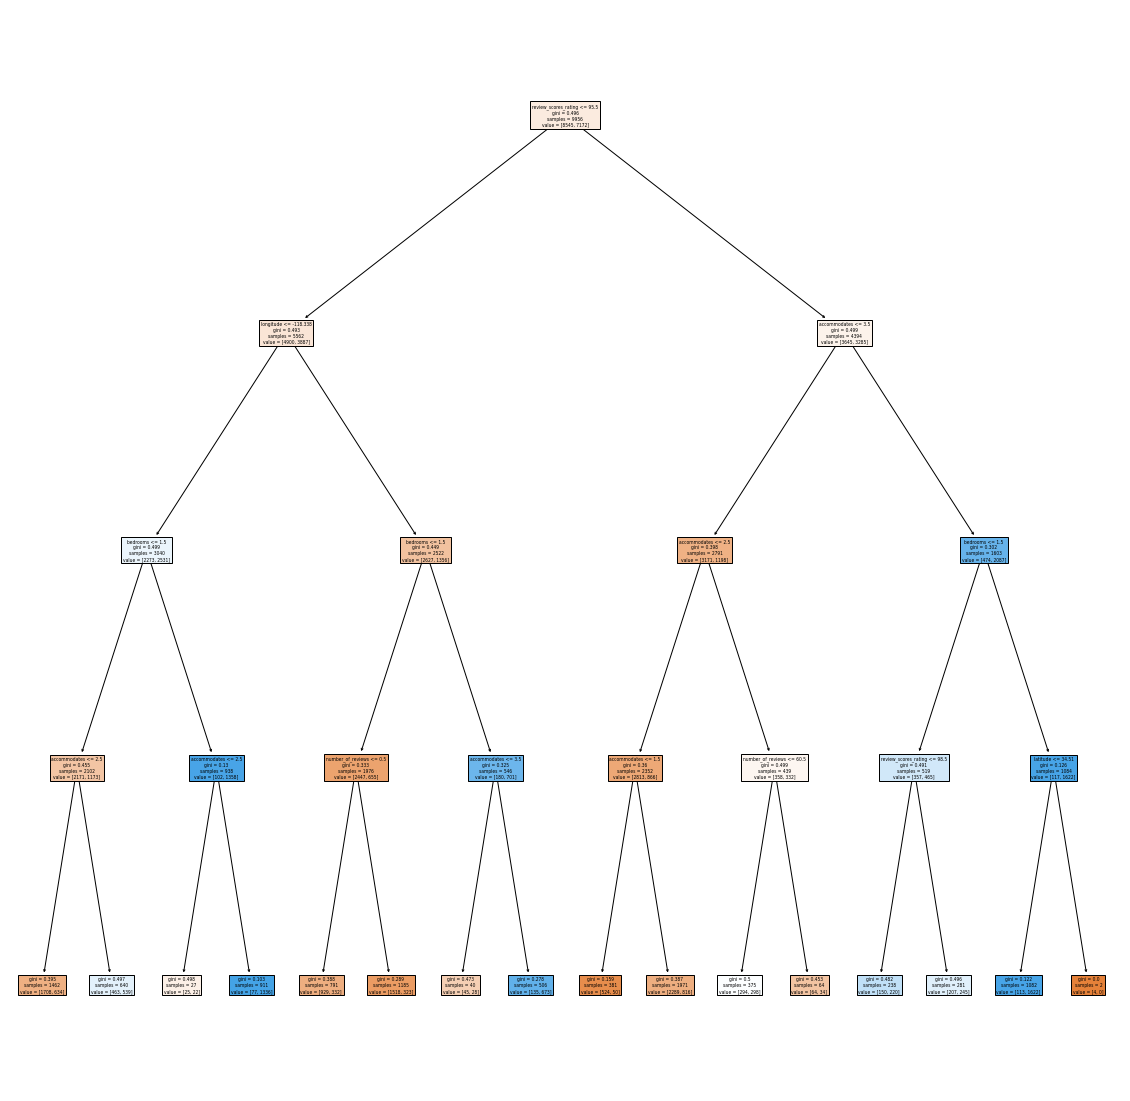

In [20]:
X3_raw = rawrf.drop(['log_price'], axis=1)
y3_raw = rawrf.log_price
# Splitting data to train and test
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_raw,y3_raw,train_size=0.7,random_state=1234)
 
forest_raw = RandomForestClassifier(n_estimators = 10, random_state = 0, max_depth=4)
Random_Forest_raw= forest_raw.fit(X3_train,y3_train)
 
rfpred_raw = forest_raw.predict(X3_test)
#Random Forest 
fig_raw = plt.figure(figsize =(20,20))
tree.plot_tree(Random_Forest_raw.estimators_[1], feature_names=list(X3_raw),filled=True)

accuracy score: 0.7853325415676959
[[3341  388]
 [1058 1949]]
              precision    recall  f1-score   support

         0.0       0.76      0.90      0.82      3729
         1.0       0.83      0.65      0.73      3007

    accuracy                           0.79      6736
   macro avg       0.80      0.77      0.78      6736
weighted avg       0.79      0.79      0.78      6736



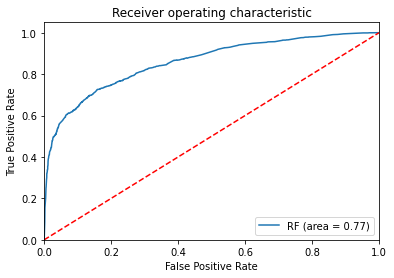

In [21]:
#ROC FOR RF
print("accuracy score:", accuracy_score(rfpred_raw, y3_test))
 
conf_mat_rawrf = confusion_matrix(y3_test, rfpred_raw)
 
print(conf_mat_rawrf)
 
print(classification_report(y3_test, rfpred_raw))

#ROC
rf_roc_auc_raw = roc_auc_score(y3_test, forest_raw.predict(X3_test))
fpr, tpr, thresholds = roc_curve(y3_test, forest_raw.predict_proba(X3_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RF (area = %0.2f)' % rf_roc_auc_raw)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

In [22]:
#KNN
#import packages
#from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [23]:
scaler = StandardScaler() 
scaler.fit(X_rawlr)  
x_feature= scaler.transform(X_rawlr)   
kfeature_train, kfeature_test, ktarget_train, ktarget_test = train_test_split(X_rawlr, y_rawlr, test_size=0.3,random_state=0)

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

knn_params = {'knn__n_neighbors': range(1, 10)}

knn_grid = GridSearchCV(knn_pipe, knn_params,
                        cv=5, n_jobs=-1, verbose=True)

knn_grid.fit(kfeature_train,ktarget_train)

knn_grid.best_params_, knn_grid.best_score_


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.7s finished


({'knn__n_neighbors': 8}, 0.7954437301196001)

In [25]:
knn_raw=KNeighborsClassifier(n_neighbors=8)
knn_raw.fit(kfeature_train,ktarget_train)
knn_pred_raw = knn_raw.predict(kfeature_test)
print(knn_pred_raw)

[0. 0. 0. ... 1. 0. 0.]


accuracy score: 0.7519299287410927
[[3230  467]
 [1204 1835]]
              precision    recall  f1-score   support

         0.0       0.73      0.87      0.79      3697
         1.0       0.80      0.60      0.69      3039

    accuracy                           0.75      6736
   macro avg       0.76      0.74      0.74      6736
weighted avg       0.76      0.75      0.75      6736



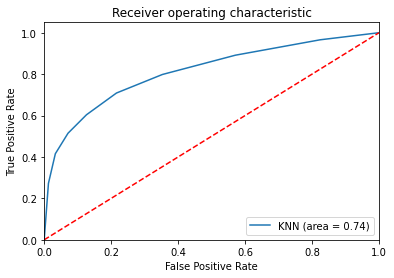

In [26]:
print("accuracy score:", accuracy_score(ktarget_test , knn_pred_raw))

conf_matraw = confusion_matrix(ktarget_test, knn_pred_raw)
print(conf_matraw)

print(classification_report(ktarget_test, knn_pred_raw))

#ROC
knn_roc_auc_raw = roc_auc_score(ktarget_test, knn_raw.predict(kfeature_test))
fpr, tpr, thresholds = roc_curve(ktarget_test, knn_raw.predict_proba(kfeature_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='KNN (area = %0.2f)' % knn_roc_auc_raw)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('KNN_ROC')
plt.show()

## Processing

## Heat map

In [27]:
#delete missing data  why we choose these variables
c = cdata.dropna()
d = pd.DataFrame(c, columns=['log_price','bathrooms','accommodates','number_of_reviews','review_scores_rating','bed_type','bedrooms','beds','city','room_type','cancellation_policy','host_has_profile_pic','host_identity_verified', 'host_response_rate','instant_bookable','cleaning_fee', 'latitude', 'longitude'])
la = d[d.city=="LA"]

In [28]:
la_c =la.copy()
la_c['cleaning_fee'] = la.cleaning_fee.astype(int)
#convert str% to numeric
h_float = la_c['host_response_rate'].str.strip("%").astype(float)/100
la_c['host_response_rate']=h_float
la_c.loc[la_c['host_response_rate'] ==1 ,'host_response_rate'] = 1
la_c.loc[la_c['host_response_rate'] != 1 ,'host_response_rate'] = 0

la_c.loc[la_c["bed_type"] == "Real Bed","bed_type"] = 1
la_c.loc[la_c["bed_type"] == "Futon","bed_type"] = 0
la_c.loc[la_c["bed_type"] == "Pull-out Sofa","bed_type"] = 0
la_c.loc[la_c["bed_type"] == "Airbed","bed_type"] = 0
la_c.loc[la_c["bed_type"] == "Couch","bed_type"] = 0

la_c.loc[la_c["room_type"] == "Private room","room_type"] = 0
la_c.loc[la_c["room_type"] == "Shared room","room_type"] = 0
la_c.loc[la_c["room_type"] == "Entire home/apt","room_type"] = 1


la_c.loc[la_c["cancellation_policy"] == "strict" ,"cancellation_policy"] = 0
la_c.loc[la_c["cancellation_policy"] =="super_strict_60" ,"cancellation_policy"] = 0
la_c.loc[la_c["cancellation_policy"] =="super_strict_30" ,"cancellation_policy"] = 0
la_c.loc[la_c["cancellation_policy"] == "moderate","cancellation_policy"] = 1
la_c.loc[la_c["cancellation_policy"] == "flexible","cancellation_policy"] = 1

la_c.loc[la_c['host_has_profile_pic'] == "f",'host_has_profile_pic'] = 0
la_c.loc[la_c['host_has_profile_pic'] == "t",'host_has_profile_pic'] = 1

la_c.loc[la_c['host_identity_verified'] == "f",'host_identity_verified'] = 0
la_c.loc[la_c['host_identity_verified'] == "t",'host_identity_verified'] = 1

la_c.loc[la_c['instant_bookable'] == "f",'instant_bookable'] = 0
la_c.loc[la_c['instant_bookable'] == "t",'instant_bookable'] = 1

la_c.loc[la_c["log_price"] <4.72,"log_price"] = 0
la_c.loc[la_c["log_price"] >=4.72,"log_price"] = 1

In [29]:
la_h = la_c.drop(['city'],axis =1)
#convert object to numeric
objlist = ['room_type','bed_type','cancellation_policy','host_has_profile_pic','host_identity_verified','instant_bookable']
for obj in objlist:
    la_h[obj] = la_h[obj].astype(float)


In [30]:
la_h

,log_price,bathrooms,accommodates,number_of_reviews,review_scores_rating,bed_type,bedrooms,beds,room_type,cancellation_policy,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,cleaning_fee,latitude,longitude
6,0.0,1.0,3,15,97.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1,33.980454,-118.462821
7,1.0,1.0,2,9,93.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1,34.046737,-118.260439
9,0.0,1.0,2,2,90.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1,33.992563,-117.895997
11,1.0,1.5,4,29,97.0,1.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,1,33.875862,-118.403293
12,0.0,1.0,2,0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1,33.813228,-118.389434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74101,0.0,1.0,1,4,90.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1,34.020021,-118.498239
74102,0.0,3.0,10,1,80.0,1.0,1.0,10.0,0.0,1.0,1.0,0.0,1.0,0.0,0,34.199671,-118.618070
74105,0.0,1.0,2,36,91.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1,34.092640,-118.343921
74107,1.0,2.0,4,16,93.0,1.0,2.0,4.0,1.0,1.0,1.0,0.0,1.0,0.0,1,33.871549,-118.396053


## Correlation map

## pearson selection

<AxesSubplot:>

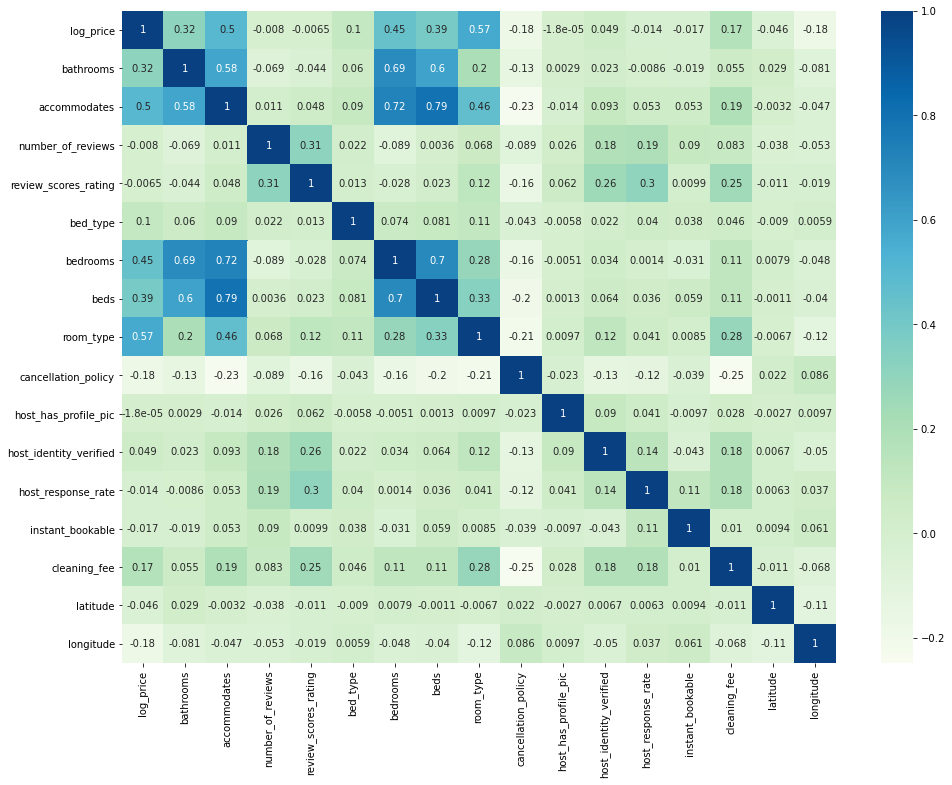

In [31]:
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12))
sns.heatmap(la_h.corr(),cmap='GnBu',annot=True)

#sns.heatmap(uniform_data)

In [32]:
# %matplotlib qt
%matplotlib inline

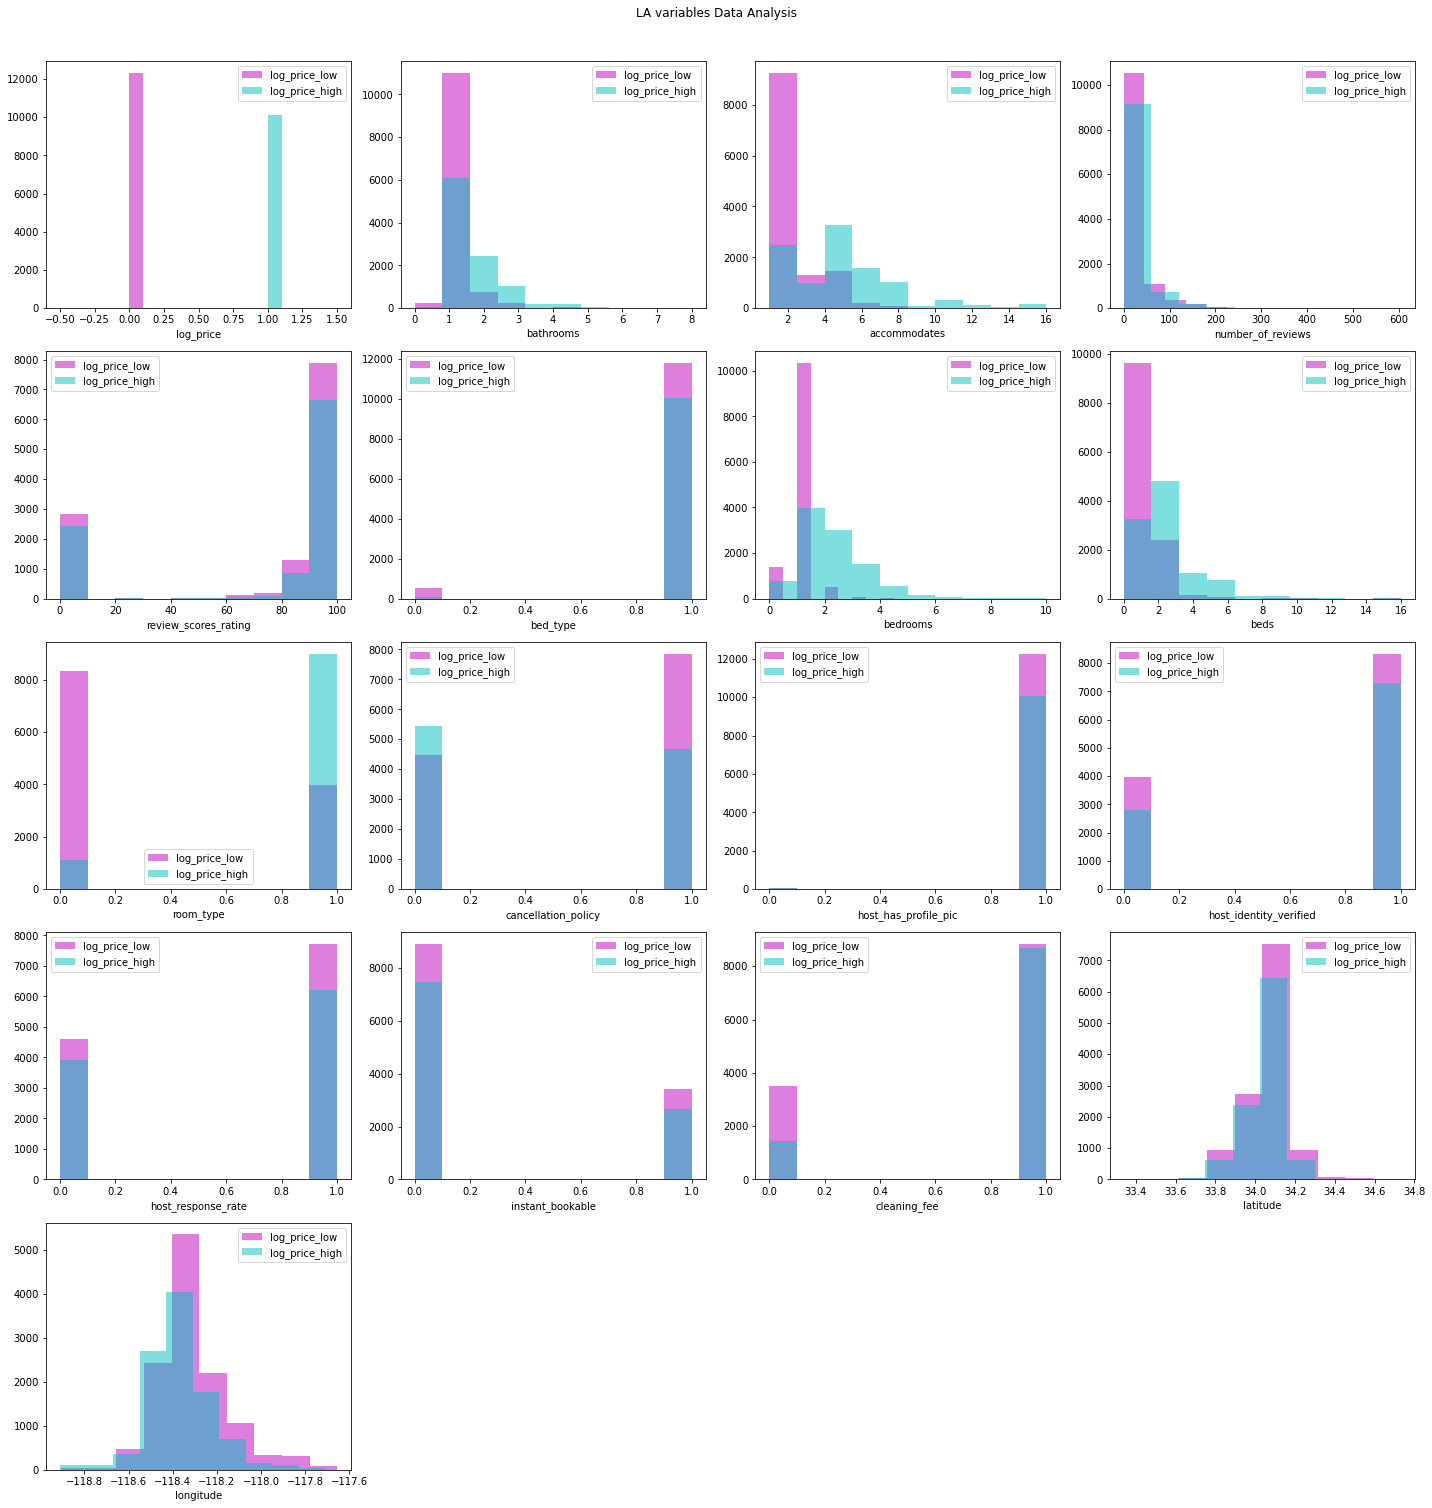

In [33]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in la_h.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    plt.hist(la_h[i][result['log_price']==0],alpha = 0.5, color = "m", label = 'log_price_low')
    plt.hist(la_h[i][result['log_price']==1],alpha = 0.5, color = "c", label = 'log_price_high')
    plt.legend(loc='best')
    plt.xlabel(i)
fig.suptitle('LA variables Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [34]:
cor = la_h.corr()
#Correlation with output variable
cor_target = abs(cor["log_price"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.30]
relevant_features

log_price       1.000000
bathrooms       0.315419
accommodates    0.498019
bedrooms        0.448653
beds            0.389033
room_type       0.569489
Name: log_price, dtype: float64

<AxesSubplot:>

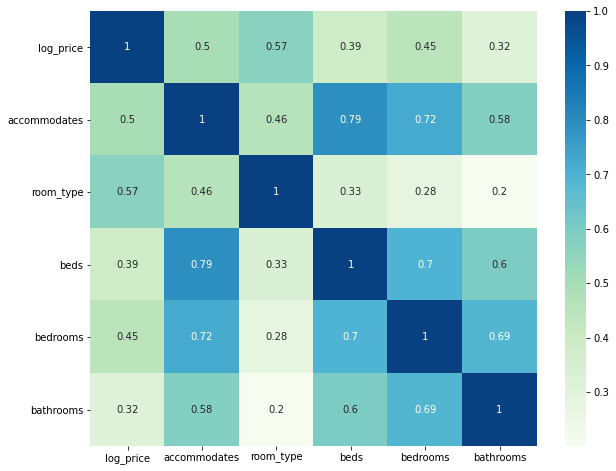

In [35]:
rele = pd.DataFrame(la_h, columns=['log_price','accommodates', 'room_type',"beds","bedrooms", "bathrooms"])
plt.figure(figsize=(10, 8))
sns.heatmap(rele.corr(),cmap='GnBu',annot=True)

In [36]:
#we set 70% threshold to prevent the high correlation between these variables
la_d= pd.DataFrame(la_h,columns=['log_price','accommodates', 'room_type',"bathrooms"])

In [37]:
# 75% threshold
la_d1 = pd.DataFrame(la_h,columns=['log_price','accommodates', 'room_type',"bathrooms", "bedrooms"])

In [38]:
# no threshold
la_d2 = pd.DataFrame(la_h,columns=['log_price','accommodates', 'room_type',"bathrooms", "bedrooms", "beds"])

## Logistic Regression

In [39]:
#logisticRegression
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [40]:
# 70% threshold
# Splitting data to X and y
LALR = la_d.copy()
X2_lr = LALR.drop(['log_price'], axis=1)
y2_lr = LALR.log_price

# Splitting data to train and test
from sklearn.model_selection import train_test_split
X2_la_LRtrain, X2_la_LRtest, y2_la_LRtrain, y2_la_LRtest = train_test_split(X2_lr,y2_lr,train_size=0.7,random_state=1234)


In [41]:
# 70% threshold
#regression result
logreg = LogisticRegression()
logreg.fit(X2_la_LRtrain, y2_la_LRtrain)
est = sm.Logit(y2_la_LRtrain, X2_la_LRtrain.astype(float)).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.606913
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              log_price   No. Observations:                15717
Model:                          Logit   Df Residuals:                    15714
Method:                           MLE   Df Model:                            2
Date:                Wed, 09 Dec 2020   Pseudo R-squ.:                  0.1188
Time:                        16:01:22   Log-Likelihood:                -9538.8
converged:                       True   LL-Null:                       -10825.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
accommodates     0.2665      0.012     21.353      0.000       0.242       0.291
room_type        1.1032

Accuracy of logistic regression  classifier on test set: 0.80
Confusion Matrix
[[3119  610]
 [ 740 2267]]
              precision    recall  f1-score   support

         0.0       0.81      0.84      0.82      3729
         1.0       0.79      0.75      0.77      3007

    accuracy                           0.80      6736
   macro avg       0.80      0.80      0.80      6736
weighted avg       0.80      0.80      0.80      6736



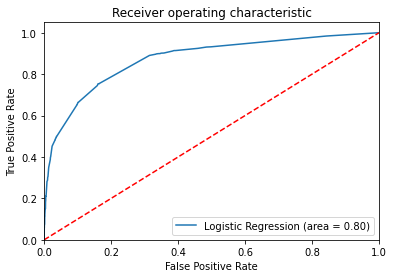

In [42]:
# 70% 
#accuracy
y_predition = logreg.predict(X2_la_LRtest)
print('Accuracy of logistic regression  classifier on test set: {:.2f}'.format(logreg.score(X2_la_LRtest, y2_la_LRtest)))
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y2_la_LRtest, y_predition)
print('Confusion Matrix')
print(confusion_matrix)
#report
print(classification_report(y2_la_LRtest, y_predition))
#ROC
logit_roc_auc = roc_auc_score(y2_la_LRtest, logreg.predict(X2_la_LRtest))
fpr, tpr, thresholds = roc_curve(y2_la_LRtest, logreg.predict_proba(X2_la_LRtest)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [51]:
#K-fold validation

score11 = cross_val_score(logreg, X2_lr,y2_lr, cv=kfold, scoring='accuracy')
print("Results of 10-fold validation:",scor11)
print()
print("Mean of 10-fold validation:", score11.mean())

Results of 10-fold validation: [0.7871772  0.78762244 0.78895815 0.79109131 0.79198218 0.78841871
 0.77995546 0.78396437 0.82449889 0.80489978]

Mean of 10-fold validation: 0.7928568482052727


In [43]:
# 75% threshold
LALR1 = la_d1.copy()
X2_lr1 = LALR1.drop(['log_price'], axis=1)
y2_lr1 = LALR1.log_price

# Splitting data to train and test
from sklearn.model_selection import train_test_split
X2_la_LRtrain1, X2_la_LRtest1, y2_la_LRtrain1, y2_la_LRtest1 = train_test_split(X2_lr1,y2_lr1,train_size=0.7,random_state=1234)


In [44]:
# 75% threshold
#regression result
logreg = LogisticRegression()
logreg.fit(X2_la_LRtrain1, y2_la_LRtrain1)
est1 = sm.Logit(y2_la_LRtrain1, X2_la_LRtrain1.astype(float)).fit()
print(est1.summary())

Optimization terminated successfully.
         Current function value: 0.588299
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              log_price   No. Observations:                15717
Model:                          Logit   Df Residuals:                    15713
Method:                           MLE   Df Model:                            3
Date:                Wed, 09 Dec 2020   Pseudo R-squ.:                  0.1458
Time:                        16:01:31   Log-Likelihood:                -9246.3
converged:                       True   LL-Null:                       -10825.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
accommodates     0.1277      0.013      9.630      0.000       0.102       0.154
room_type        1.2614

Accuracy of logistic regression  classifier on test set: 0.81
Confusion Matrix
[[2957  772]
 [ 532 2475]]
              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82      3729
         1.0       0.76      0.82      0.79      3007

    accuracy                           0.81      6736
   macro avg       0.80      0.81      0.81      6736
weighted avg       0.81      0.81      0.81      6736



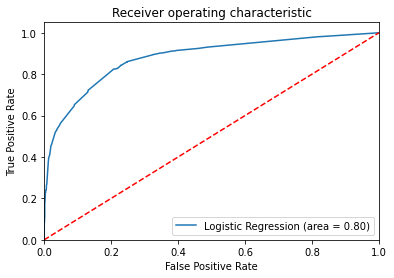

In [45]:
# 75% threshold
#accuracy
y_predition1 = logreg.predict(X2_la_LRtest1)
print('Accuracy of logistic regression  classifier on test set: {:.2f}'.format(logreg.score(X2_la_LRtest1, y2_la_LRtest1)))
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix1 = confusion_matrix(y2_la_LRtest1, y_predition1)
print('Confusion Matrix')
print(confusion_matrix1)
#report
print(classification_report(y2_la_LRtest1, y_predition1))
#ROC
logit_roc_auc1 = roc_auc_score(y2_la_LRtest1, logreg.predict(X2_la_LRtest1))
fpr, tpr, thresholds = roc_curve(y2_la_LRtest1, logreg.predict_proba(X2_la_LRtest1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [52]:
#K-fold validation

score12 = cross_val_score(logreg, X2_lr1,y2_lr1, cv=kfold, scoring='accuracy')
print("Results of 10-fold validation:",score12)
print()
print("Mean of 10-fold validation:", score12.mean())

Results of 10-fold validation: [0.7871772  0.78762244 0.78895815 0.79109131 0.79198218 0.78841871
 0.77995546 0.78396437 0.82449889 0.80489978]

Mean of 10-fold validation: 0.7988683073298336


In [46]:
# no threshold
LALR2 = la_d2.copy()
X2_lr2 = LALR2.drop(['log_price'], axis=1)
y2_lr2 = LALR2.log_price

# Splitting data to train and test
from sklearn.model_selection import train_test_split
X2_la_LRtrain2, X2_la_LRtest2, y2_la_LRtrain2, y2_la_LRtest2 = train_test_split(X2_lr2,y2_lr2,train_size=0.7,random_state=1234)

In [47]:
# no threshold
#regression result
logreg = LogisticRegression()
logreg.fit(X2_la_LRtrain2, y2_la_LRtrain2)
est2 = sm.Logit(y2_la_LRtrain2, X2_la_LRtrain2.astype(float)).fit()
print(est2.summary())

Optimization terminated successfully.
         Current function value: 0.587713
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              log_price   No. Observations:                15717
Model:                          Logit   Df Residuals:                    15712
Method:                           MLE   Df Model:                            4
Date:                Wed, 09 Dec 2020   Pseudo R-squ.:                  0.1467
Time:                        16:01:36   Log-Likelihood:                -9237.1
converged:                       True   LL-Null:                       -10825.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
accommodates     0.1678      0.017     10.155      0.000       0.135       0.200
room_type        1.2614

Accuracy of logistic regression  classifier on test set: 0.81
Confusion Matrix
[[2960  769]
 [ 534 2473]]
              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82      3729
         1.0       0.76      0.82      0.79      3007

    accuracy                           0.81      6736
   macro avg       0.80      0.81      0.81      6736
weighted avg       0.81      0.81      0.81      6736



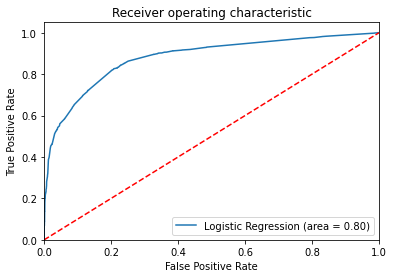

In [48]:
# no threshold
#accuracy
y_predition2 = logreg.predict(X2_la_LRtest2)
print('Accuracy of logistic regression  classifier on test set: {:.2f}'.format(logreg.score(X2_la_LRtest2, y2_la_LRtest2)))
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix2 = confusion_matrix(y2_la_LRtest2, y_predition2)
print('Confusion Matrix')
print(confusion_matrix2)
#report
print(classification_report(y2_la_LRtest2, y_predition2))
#ROC
logit_roc_auc2 = roc_auc_score(y2_la_LRtest2, logreg.predict(X2_la_LRtest2))
fpr, tpr, thresholds = roc_curve(y2_la_LRtest2, logreg.predict_proba(X2_la_LRtest2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [53]:
#K-fold validation

score13 = cross_val_score(logreg, X2_lr2,y2_lr2, cv=kfold, scoring='accuracy')
print("Results of 10-fold validation:",score13)
print()
print("Mean of 10-fold validation:", score13.mean())

Results of 10-fold validation: [0.79385574 0.7969724  0.7983081  0.79376392 0.80445434 0.80044543
 0.80356347 0.80089087 0.8013363  0.7986637 ]

Mean of 10-fold validation: 0.7992254282297458


## Naive Bayes

In [55]:
#Naive Bayes
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
# from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
# from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [56]:
# 70% threshold 
lanb = la_d.copy()
lanb.loc[lanb["accommodates"] <3.41,"accommodates"] = 0
lanb.loc[lanb["accommodates"] >=3.41,"accommodates"] = 1

lanb.loc[lanb["bathrooms"] <1.34,"bathrooms"] = 0
lanb.loc[lanb["bathrooms"] >=1.34,"bathrooms"] = 1

<AxesSubplot:>

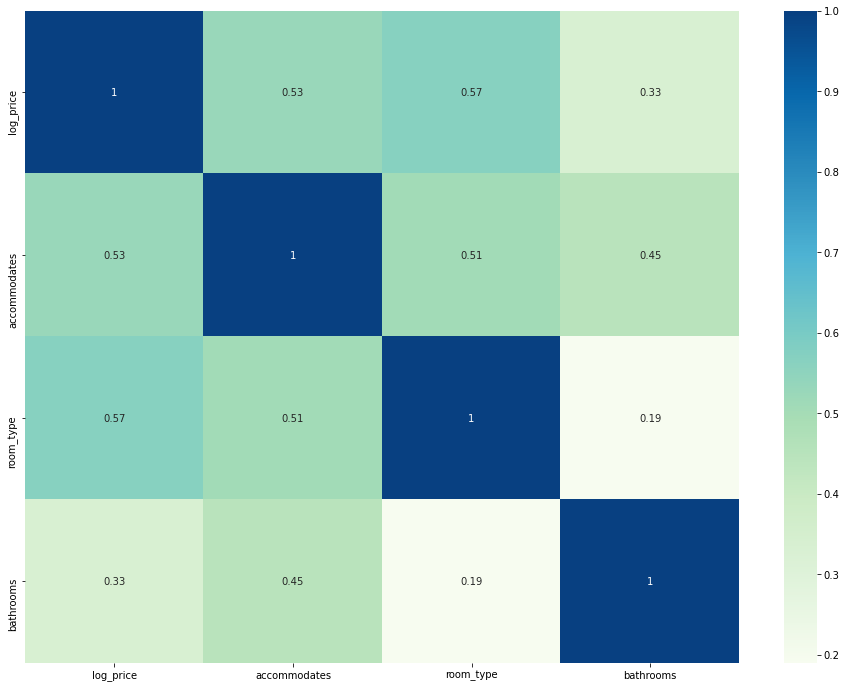

In [57]:
plt.figure(figsize=(16, 12))
sns.heatmap(lanb.corr(),cmap='GnBu',annot=True)

In [58]:
# 70% threshold
X_feature=lanb.drop(['log_price'],axis =1).values
x_target=lanb.log_price.values

accuracy score: 0.7776128266033254
[[3272  425]
 [1073 1966]]
              precision    recall  f1-score   support

         0.0       0.75      0.89      0.81      3697
         1.0       0.82      0.65      0.72      3039

    accuracy                           0.78      6736
   macro avg       0.79      0.77      0.77      6736
weighted avg       0.78      0.78      0.77      6736



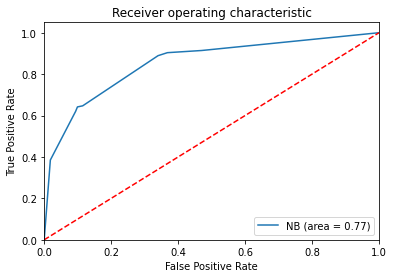

In [59]:
 # 70% threshold
feature_train, feature_test, target_train, target_test = train_test_split(X_feature, x_target, test_size=0.3,random_state=0)

NB=BernoulliNB()
NB.fit(feature_train,target_train)
predict_results=NB.predict(feature_test)
print("accuracy score:", accuracy_score(predict_results, target_test))

conf_mat = confusion_matrix(target_test, predict_results)
print(conf_mat)

print(classification_report(target_test, predict_results))
#ROC
nb_roc_auc = roc_auc_score(target_test, NB.predict(feature_test))
fpr, tpr, thresholds = roc_curve(target_test, NB.predict_proba(feature_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='NB (area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('NB_ROC')
plt.show()

In [60]:
#K-fold validation

score14 = cross_val_score(NB, X_feature, x_target, cv=kfold, scoring='accuracy')
print("Results of 10-fold validation:",score14)
print()
print("Mean of 10-fold validation:", score14.mean())

Results of 10-fold validation: [0.78495102 0.77827248 0.79519145 0.77728285 0.78708241 0.7857461
 0.7857461  0.79109131 0.79510022 0.77104677]

Mean of 10-fold validation: 0.7851510728302927


In [61]:
# 75% threshold 
lanb1 = la_d1.copy()
lanb1.loc[lanb1["accommodates"] <3.41,"accommodates"] = 0
lanb1.loc[lanb1["accommodates"] >=3.41,"accommodates"] = 1

lanb1.loc[lanb1["bathrooms"] <1.34,"bathrooms"] = 0
lanb1.loc[lanb1["bathrooms"] >=1.34,"bathrooms"] = 1

lanb1.loc[lanb1["bedrooms"] <1.33,"bedrooms"] = 0
lanb1.loc[lanb1["bedrooms"] >=1.33,"bedrooms"] = 1

In [62]:
# 75% threshold
X_feature1=lanb1.drop(['log_price'],axis =1).values
x_target1=lanb1.log_price.values

accuracy score: 0.7862232779097387
[[3286  411]
 [1029 2010]]
              precision    recall  f1-score   support

         0.0       0.76      0.89      0.82      3697
         1.0       0.83      0.66      0.74      3039

    accuracy                           0.79      6736
   macro avg       0.80      0.78      0.78      6736
weighted avg       0.79      0.79      0.78      6736



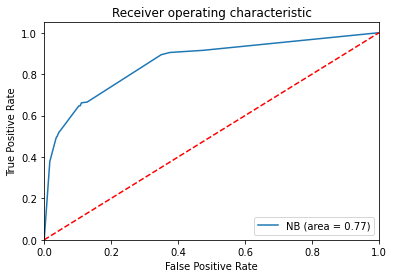

In [63]:
 # 75% threshold
feature_train1, feature_test1, target_train1, target_test1 = train_test_split(X_feature1, x_target1, test_size=0.3,random_state=0)

NB=BernoulliNB()
NB.fit(feature_train1,target_train1)
predict_results1=NB.predict(feature_test1)
print("accuracy score:", accuracy_score(predict_results1, target_test1))

conf_mat1 = confusion_matrix(target_test1, predict_results1)
print(conf_mat1)

print(classification_report(target_test1, predict_results1))
#ROC
nb_roc_auc1 = roc_auc_score(target_test1, NB.predict(feature_test1))
fpr, tpr, thresholds = roc_curve(target_test1, NB.predict_proba(feature_test1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='NB (area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('NB_ROC')
plt.show()

In [64]:
#K-fold validation

score15 = cross_val_score(NB, X_feature1, x_target1, cv=kfold, scoring='accuracy')
print("Results of 10-fold validation:",score15)
print()
print("Mean of 10-fold validation:", score15.mean())

Results of 10-fold validation: [0.79875334 0.78851291 0.79252004 0.79732739 0.79376392 0.78619154
 0.79688196 0.77371938 0.79331849 0.79465479]

Mean of 10-fold validation: 0.7915643747756468


In [65]:
# no threshold 
lanb2 = la_d2.copy()
lanb2.loc[lanb2["accommodates"] <3.41,"accommodates"] = 0
lanb2.loc[lanb2["accommodates"] >=3.41,"accommodates"] = 1

lanb2.loc[lanb2["bathrooms"] <1.34,"bathrooms"] = 0
lanb2.loc[lanb2["bathrooms"] >=1.34,"bathrooms"] = 1

lanb2.loc[lanb2["bedrooms"] <1.33,"bedrooms"] = 0
lanb2.loc[lanb2["bedrooms"] >=1.33,"bedrooms"] = 1

lanb2.loc[lanb2["beds"] <1.86,"beds"] = 0
lanb2.loc[lanb2["beds"] >=1.86,"beds"] = 1

In [66]:
# no threshold
X_feature2=lanb2.drop(['log_price'],axis =1).values
x_target2=lanb2.log_price.values

accuracy score: 0.7782066508313539
[[3258  439]
 [1055 1984]]
              precision    recall  f1-score   support

         0.0       0.76      0.88      0.81      3697
         1.0       0.82      0.65      0.73      3039

    accuracy                           0.78      6736
   macro avg       0.79      0.77      0.77      6736
weighted avg       0.78      0.78      0.77      6736



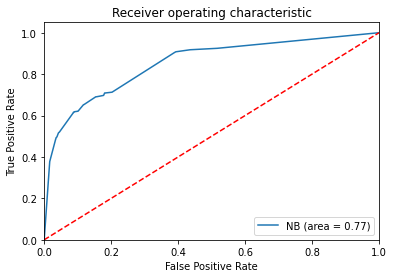

In [67]:
 # no threshold
feature_train2, feature_test2, target_train2, target_test2 = train_test_split(X_feature2, x_target2, test_size=0.3,random_state=0)

NB=BernoulliNB()
NB.fit(feature_train2,target_train2)
predict_results2=NB.predict(feature_test2)
print("accuracy score:", accuracy_score(predict_results2, target_test2))

conf_mat2 = confusion_matrix(target_test2, predict_results2)
print(conf_mat2)

print(classification_report(target_test2, predict_results2))
#ROC
nb_roc_auc2 = roc_auc_score(target_test2, NB.predict(feature_test2))
fpr, tpr, thresholds = roc_curve(target_test2, NB.predict_proba(feature_test2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='NB (area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('NB_ROC')
plt.show()

In [68]:
#K-fold validation

score16 = cross_val_score(NB, X_feature2, x_target2, cv=kfold, scoring='accuracy')
print("Results of 10-fold validation:",score16)
print()
print("Mean of 10-fold validation:", score16.mean())

Results of 10-fold validation: [0.79652716 0.79385574 0.7858415  0.77060134 0.79064588 0.78129176
 0.77728285 0.77550111 0.78040089 0.77728285]

Mean of 10-fold validation: 0.7829231080445911


## Random Forest

In [69]:
# 75% threshold
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
larf = la_d1.copy()
X2 = larf.drop(['log_price'], axis=1)
y2 = larf.log_price
# Splitting data to train and test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,train_size=0.7,random_state=1234)

In [70]:
# 75% threshold 
forest = RandomForestClassifier(n_estimators = 10, random_state = 0, max_depth=4)
Random_Forest= forest.fit(X2_train,y2_train)
from sklearn.model_selection import cross_val_score
print(np.mean(cross_val_score(forest, X2_train, y2_train, cv=10))) 
rfpred = forest.predict(X2_test)
#random forest cross validation score

0.7986902800925814


[Text(587.8928571428571, 978.48, 'bedrooms <= 1.5\ngini = 0.496\nsamples = 9956\nvalue = [8545, 7172]'),
 Text(318.85714285714283, 761.0400000000001, 'accommodates <= 2.5\ngini = 0.418\nsamples = 7328\nvalue = [8118, 3432]'),
 Text(159.42857142857142, 543.6, 'bedrooms <= 0.5\ngini = 0.345\nsamples = 5166\nvalue = [6350, 1808]'),
 Text(79.71428571428571, 326.1600000000001, 'bathrooms <= 1.75\ngini = 0.439\nsamples = 665\nvalue = [709, 343]'),
 Text(39.857142857142854, 108.72000000000003, 'gini = 0.437\nsamples = 660\nvalue = [708, 337]'),
 Text(119.57142857142856, 108.72000000000003, 'gini = 0.245\nsamples = 5\nvalue = [1, 6]'),
 Text(239.1428571428571, 326.1600000000001, 'room_type <= 0.5\ngini = 0.327\nsamples = 4501\nvalue = [5641, 1465]'),
 Text(199.28571428571428, 108.72000000000003, 'gini = 0.198\nsamples = 3460\nvalue = [4834, 607]'),
 Text(279.0, 108.72000000000003, 'gini = 0.5\nsamples = 1041\nvalue = [807, 858]'),
 Text(478.2857142857142, 543.6, 'bathrooms <= 2.25\ngini = 0.49

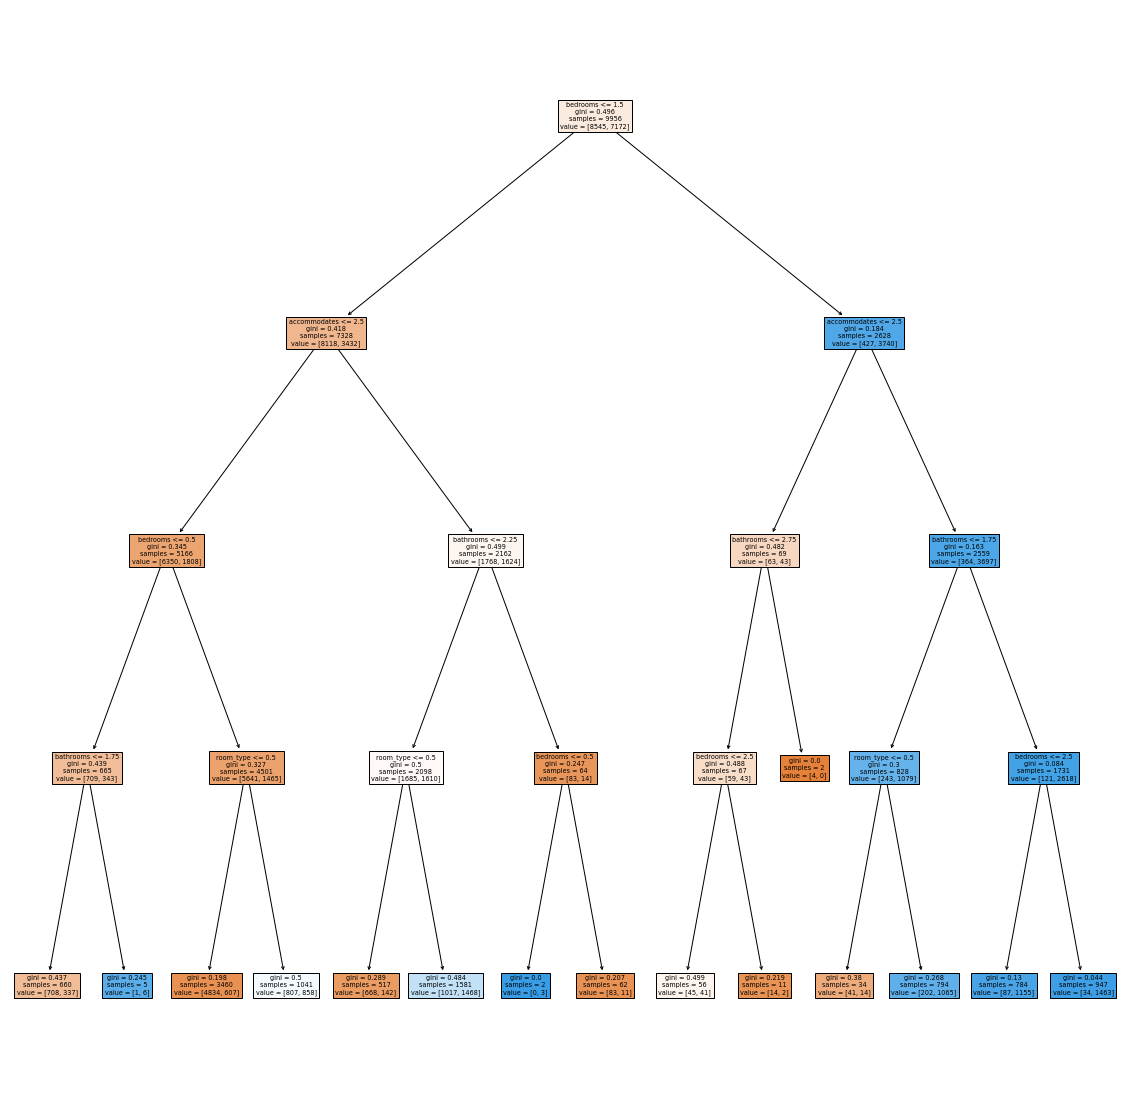

In [71]:
# 75% threshold 
#Random Forest 
fig = plt.figure(figsize =(20,20))
tree.plot_tree(Random_Forest.estimators_[1], feature_names=list(X2),filled=True)

accuracy score: 0.8058194774346793
[[3199  530]
 [ 778 2229]]
              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83      3729
         1.0       0.81      0.74      0.77      3007

    accuracy                           0.81      6736
   macro avg       0.81      0.80      0.80      6736
weighted avg       0.81      0.81      0.80      6736



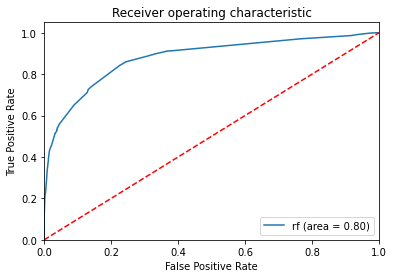

In [72]:
#X2_train, X2_test, y2_train, y2_test rfpred
print("accuracy score:", accuracy_score(rfpred, y2_test))

conf_matrf = confusion_matrix(y2_test, rfpred)
print(conf_matrf)

print(classification_report(y2_test, rfpred))

#ROC
rf_roc_auc = roc_auc_score(y2_test, forest.predict(X2_test))
fpr, tpr, thresholds = roc_curve(y2_test, forest.predict_proba(X2_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='rf (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

In [73]:
#K-fold validation

score17 = cross_val_score(forest, X2,y2, cv=kfold, scoring='accuracy')
print("Results of 10-fold validation:",score17)
print()
print("Mean of 10-fold validation:", score17.mean())

Results of 10-fold validation: [0.80409617 0.79652716 0.79608192 0.81603563 0.79465479 0.80534521
 0.78841871 0.81469933 0.79554566 0.79688196]

Mean of 10-fold validation: 0.8008286545543971


## KNN

In [74]:
#import packages
#from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [75]:
# 75% threshold 
scaler = StandardScaler() 
scaler.fit(X2_lr1)  
x_feature1 = scaler.transform(X2_lr1)   
kfeature1_train, kfeature1_test, ktarget1_train, ktarget1_test = train_test_split(X2_lr1, y2_lr1, test_size=0.3,random_state=0)

In [76]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

knn_params = {'knn__n_neighbors': range(1, 10)}

knn_grid = GridSearchCV(knn_pipe, knn_params,
                        cv=5, n_jobs=-1, verbose=True)

knn_grid.fit(kfeature1_train,ktarget1_train)

knn_grid.best_params_, knn_grid.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.0s finished


({'knn__n_neighbors': 9}, 0.7908007940420936)

In [77]:
# 75% threshold 
#feature_train, feature_test, target_train, target_test 
knn=KNeighborsClassifier(n_neighbors=9)
knn.fit(kfeature1_train,ktarget1_train)
knn_pred = knn.predict(kfeature1_test)
print(knn_pred)

[0. 0. 0. ... 1. 1. 0.]


accuracy score: 0.7719714964370546
[[3291  406]
 [1130 1909]]
              precision    recall  f1-score   support

         0.0       0.74      0.89      0.81      3697
         1.0       0.82      0.63      0.71      3039

    accuracy                           0.77      6736
   macro avg       0.78      0.76      0.76      6736
weighted avg       0.78      0.77      0.77      6736



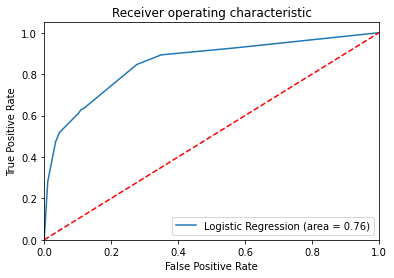

In [78]:
# 75% threshold 
print("accuracy score:", accuracy_score(knn_pred, ktarget1_test))

conf_matknn = confusion_matrix(ktarget1_test, knn_pred)
print(conf_matknn)

print(classification_report(ktarget1_test, knn_pred))

#feature_train, feature_test, target_train, target_test 
#ROC
knn_roc_auc = roc_auc_score(ktarget1_test , knn.predict(kfeature1_test))
fpr, tpr, thresholds = roc_curve(ktarget1_test, knn.predict_proba(kfeature1_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('knn_ROC')
plt.show()

In [79]:
#K-fold validation

score18 = cross_val_score(knn, X2_lr1, y2_lr1, cv=kfold, scoring='accuracy')
print("Results of 10-fold validation:",score18)
print()
print("Mean of 10-fold validation:", score18.mean())

Results of 10-fold validation: [0.76625111 0.7920748  0.79474622 0.80356347 0.7844098  0.78040089
 0.79242762 0.79020045 0.79732739 0.79510022]

Mean of 10-fold validation: 0.7896501972325957


## Thank you!